In [8]:
# !pip install nvidia-cudnn-cu11==8.6.0.163 tensorflow==2.13.*

In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
# import keras
import numpy as np

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# conect drive files with the colab
# https://www.tensorflow.org/tutorials/load_data/images
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# TO RUN ON CPU ONLY

# # Create a TensorFlow session configuration that forces CPU execution
# config = tf.compat.v1.ConfigProto(device_count={'GPU': 0})  # 0 means no GPUs

# # Create a TensorFlow session with the specified configuration
# session = tf.compat.v1.Session(config=config)

# # Set the session as the default session for Keras
# tf.compat.v1.keras.backend.set_session(session)

In [3]:
# Caminho para o diretório principal do dataset
# dataset_dir = 'drive/MyDrive/dataset/diabetic rinopaty/test' # drive directory

# train_dir = 'E:\\documentos\\tcc\dataset1\\train' # local directory
# train_dir = 'E:\\retinopatia-dataset\\train' # local directory
# test_dir = 'E:\\documentos\\tcc\dataset1\\test' # local directory

# labels_file = 'E:\\retinopatia-dataset\\trainLabels.csv'
# labels_df = pd.read_csv(labels_file)
# labels_df['level'] = labels_df['level'].astype(str)

train_dir = 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb' # local directory

labels_file = "E:\\retinopatia-resized\\trainLabels_equalized.csv"
labels_df = pd.read_csv(labels_file)
labels_df['level'] = labels_df['level'].astype(str)


In [4]:
print(np.count_nonzero(labels_df['level'] == '0'))
print(np.count_nonzero(labels_df['level'] == '1'))
print(np.count_nonzero(labels_df['level'] == '2'))
print(np.count_nonzero(labels_df['level'] == '3'))
print(np.count_nonzero(labels_df['level'] == '4'))
print("-"*10)
print(np.count_nonzero(labels_df['image']))

25802
2438
5288
872
708
----------
35108


In [5]:
def augmentate(X_train, y_train, INPUT_SHAPE, BATCH_SIZE):
    augment_classes = ['1', '2', '3', '4']
    # Separe os exemplos em grupos com base nas classes
    x_train_augment = []
    y_train_augment = []

    # for i in range(len(y_train)):
    #     if y_train[i][0] in augment_classes:
    #         x_train_augment.append(X_train[i])
    #         y_train_augment.append(y_train[i])
    #     else:
    #         x_train_augment.

    i = 0
    count = 0
    while True:
        if i >= len(y_train):
            break
        
        if y_train[i][0] == '1':
            # continue
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
        # if y_train[i][0] == '2':
        #     continue
        #     x_train_augment.append(X_train[i])
        #     y_train_augment.append(y_train[i])
        elif y_train[i][0] == '3':
            # continue
            # for i in range(12):
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
        elif y_train[i][0] == '4':
            # continue
            # for i in range(15):
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])
            x_train_augment.append(X_train[i])
            y_train_augment.append(y_train[i])

        if y_train[i][0] == '0' and count <= 3000:
            count += 1
        elif y_train[i][0] == '0' and  count > 3000:
            X_train = X_train[0:i] + X_train[i+1:]
            y_train = y_train[0:i] + y_train[i+1:]
            i -= 1
        i += 1

    print("qtd x_train_augment:", np.count_nonzero(x_train_augment))
    print("qtd y_train_augment:", np.count_nonzero(y_train_augment))

    print("qtd X_train(augm):", np.count_nonzero(X_train))
    print("qtd y_train(augm):", np.count_nonzero(y_train))

    X_train = X_train + x_train_augment
    y_train = y_train + y_train_augment

    print("qtd X_train(augm)2:", np.count_nonzero(X_train))
    print("qtd y_train(augm)2:", np.count_nonzero(y_train))

    datagen = ImageDataGenerator(
            rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1]
            rotation_range=270,
            horizontal_flip=True,
    )
    # zoom_range=0.2,
    # fill_mode='nearest'
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,

    print("qtd X_train(augm)3:", np.count_nonzero(X_train))
    print("qtd y_train(augm)3:", np.count_nonzero(y_train))

    return X_train, y_train, datagen.flow_from_dataframe(
            pd.DataFrame({'image': X_train, 'level': y_train}),
            directory='.',  # O diretório base das imagens
            x_col='image',
            y_col='level',
            target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True
        )

In [6]:
# from imblearn.over_sampling import SMOTE

# Define your hyperparameters
INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 5
EPOCHS = 20
BATCH_SIZE = 32

image_file_paths = [os.path.join(train_dir, filename + '.jpeg') for filename in labels_df['image']]
labels = labels_df['level']

# Embaralhe os dados
data = list(zip(image_file_paths, labels))
random.shuffle(data)
image_file_paths, labels = zip(*data)

# Divida o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(image_file_paths, labels, test_size=0.2, random_state=42)

# Divida o conjunto de treinamento em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train)
print(X_val)
print(y_val)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# X_train = X_train.reshape(-1, 1)
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# train_generator = train_datagen.flow_from_dataframe(
#     pd.DataFrame({'image': X_train, 'level': y_train}),
#     directory='.',  # O diretório base das imagens
#     x_col='image',
#     y_col='level',
#     target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical')  # Se for um problema de classificação

# def extract_green_channel(x):
#     # Assuming the original image is RGB, we use [:, :, 0] to extract the Red channel.
#     green_channel = x[:, :, 1:2]
#     return green_channel
print("qtd img:", np.count_nonzero(X_train))
print("qtd labels:", np.count_nonzero(y_train))

X_train, y_train, train_generator = augmentate(X_train, y_train, INPUT_SHAPE, BATCH_SIZE)

print("qtd img:", np.count_nonzero(X_train))
print("qtd labels:", np.count_nonzero(y_train))

validation_generator = validation_datagen.flow_from_dataframe(
    pd.DataFrame({'image': X_val, 'level': y_val}),
    directory='.',  # O diretório base das imagens
    x_col='image',
    y_col='level',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'image': X_test, 'level': y_test}),
    directory='.',  # O diretório base das imagens
    x_col='image',
    y_col='level',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  # Se for um problema de classificação

['E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\43757_right.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\21219_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\42761_right.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\42740_right.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\29332_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\30987_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\12155_right.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\643_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\37792_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\32603_left.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\38385_right.jpeg', 'E:\\retinopatia-resized\\resized_train_cropped\\equalized_pb\\31343_right.jpeg', 'E:\\retinopatia-resize

e:\programas\anaconda3\envs\tcc\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 5617 validated image filenames belonging to 5 classes.
Found 7021 validated image filenames belonging to 5 classes.


In [7]:
def show_data_quantity(y_set):
    # Use a função unique do NumPy para obter os rótulos únicos e suas contagens
    classes, counts = np.unique(y_set, return_counts=True)

    # Crie um dicionário para mapear rótulos de classe para contagens
    class_counts = dict(zip(classes, counts))

    # Exiba as contagens de cada classe
    for classe, count in class_counts.items():
        print(f"Classe {classe}: {count} amostras")

show_data_quantity(y_train)
print("-"*30)
show_data_quantity(y_val)
print("-"*30)
show_data_quantity(y_test)

Classe 0: 3001 amostras
Classe 1: 3136 amostras
Classe 2: 3368 amostras
Classe 3: 2900 amostras
Classe 4: 2250 amostras
------------------------------
Classe 0: 4139 amostras
Classe 1: 403 amostras
Classe 2: 840 amostras
Classe 3: 133 amostras
Classe 4: 103 amostras
------------------------------
Classe 0: 5161 amostras
Classe 1: 467 amostras
Classe 2: 1080 amostras
Classe 3: 159 amostras
Classe 4: 155 amostras


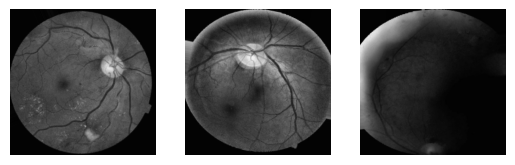

In [7]:
images, labels = next(train_generator)
image_to_plot = images[0]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image_to_plot, cmap="gray")
    plt.axis('off')

    images, labels = next(train_generator)
    image_to_plot = images[0]

plt.show()

In [19]:
# import os
# import random
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# # Lista as classes (nomes das pastas)
# classes = os.listdir(train_dir)

# # plt.figure(figsize=(10, 5))

# for i, class_name in enumerate(classes):
#     class_dir = os.path.join(train_dir, class_name)
#     random_image = random.choice(os.listdir(class_dir))
#     img_path = os.path.join(class_dir, random_image)

#     plt.subplot(1, len(classes), i + 1)
#     plt.imshow(tf.image.resize(mpimg.imread(img_path), (256, 256))[:,:,1], cmap='gray')
#     plt.title(class_name)
#     plt.axis('off')

# plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir a arquitetura da AlexNet
def create_alexnet(input_shape, num_classes):
    model = models.Sequential()

    # Camada 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape)) # 96
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 2
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu')) #256
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 3
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu')) # 348
    
    # Camada 4
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu')) # 384
    
    # Camada 5
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu')) # 256
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 6 - Flatten
    model.add(layers.Flatten())
    
    # Camada 7 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu')) # 4096
    model.add(layers.Dropout(0.5))
    
    # Camada 8 - Fully connected (Dense)
    model.add(layers.Dense(2048, activation='relu')) # 4096
    model.add(layers.Dropout(0.5))
    
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))  # 1000 classes para o ImageNet
    
    model.summary()

    return model

In [9]:
def vgg16_model(input_shape=(256, 256, 3), num_classes=5):
    input_tensor = layers.Input(shape=input_shape)

    # Bloco 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Bloco 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x) # 128
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x) # 128
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Bloco 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x) # 256
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x) # 256
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3')(x) # 256
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Bloco 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv3')(x) # 512
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Bloco 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv1')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv2')(x) # 512
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 512
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Camada totalmente conectada
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x) # 4096
    x = layers.Dense(4096, activation='relu', name='fc2')(x) # 4096
    x = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs=input_tensor, outputs=x, name='vgg16')
    
    return model

In [11]:
def residual_block(x, filters, kernel_size=3, stride=1, weight_initializer='glorot_uniform'):
    shortcut = x
    # Primeira convolução
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer=weight_initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Segunda convolução
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Conexão residual
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape, num_classes, num_blocks, num_filters, weight_initializer='glorot_uniform'):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(num_filters[0], kernel_size=7, strides=2, padding='same', kernel_initializer=weight_initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

    for i in range(len(num_blocks)):
        for j in range(num_blocks[i]):
            stride = 1 if i == 0 and j == 0 else 2
            x = residual_block(x, num_filters[i], stride=stride, weight_initializer=weight_initializer)

    x = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(x)  # Atualizado para 256x256
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

def CustomResNet(input_shape, num_classes, num_blocks, num_filters):
    model = build_resnet(input_shape, num_classes, num_blocks, num_filters, weight_initializer='glorot_uniform')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [11]:
def myModel(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    return model

In [9]:
def CustomAlexNet(learning_rate=0.001, weight_initializer='glorot_uniform', dropout_rate=0.0):
    input_shape=INPUT_SHAPE
    num_classes=NUM_CLASSES

    model = models.Sequential()

    # Camada 1
    model.add(layers.Conv2D(96, (3, 3), strides=(4, 4), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    model.add(layers.Conv2D(96, (3, 3), strides=(4, 4), activation='relu', input_shape=input_shape, kernel_initializer=weight_initializer)) # 96
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) #256
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) #256
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 348
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 348
    model.add(layers.BatchNormalization())
    
    # Camada 4
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 384
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 384
    model.add(layers.BatchNormalization())
    
    # Camada 5
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 256
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=weight_initializer)) # 256
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Camada 6 - Flatten
    model.add(layers.Flatten())
    
    # Camada 7 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu', kernel_initializer=weight_initializer)) # 4096
    model.add(layers.Dropout(dropout_rate))
    
    # Camada 8 - Fully connected (Dense)
    model.add(layers.Dense(4096, activation='relu', kernel_initializer=weight_initializer)) # 4096
    model.add(layers.Dropout(dropout_rate))
    
    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))  # 1000 classes para o ImageNet
    
    # model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), #, momentum=momentum), # adam nao tem momentum
              loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    # 'momentum': [0.5, 0.9, 0.99],
    'weight_initializer': ['glorot_uniform', 'he_normal'],
    'dropout_rate': [0.2, 0.4]
}
X, Y = train_generator.next()
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=CustomAlexNet, epochs=10, batch_size=32, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
grid_result = grid.fit(X, Y)#X_train, y_train)

In [ ]:
# Avalie os resultados
print("Melhores hiperparâmetros encontrados:", grid_result.best_params_)
print("Melhor precisão encontrada:", grid_result.best_score_)

Melhores hiperparâmetros encontrados: {'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_initializer': 'glorot_uniform'}
Melhor precisão encontrada: nan


In [ ]:
param_grid = {
    'num_filters': [[32, 64, 128, 128], [64, 64, 128, 128]],
    'num_blocks': [[3, 4, 6, 3], [3, 4, 4, 3], [3, 3, 3, 3]]
}

X, Y = train_generator.next()
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=CustomResNet, epochs=10, batch_size=32, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
grid_result = grid.fit(X, Y)#X_train, y_train)

In [ ]:
print("Melhores hiperparâmetros encontrados:", grid_result.best_params_)
print("Melhor precisão encontrada:", grid_result.best_score_)

In [ ]:
# from keras import optimizers

# Defina o número de blocos e filtros por bloco desejados
num_blocks = [3, 4, 6, 3]
num_filters = [64, 128, 256, 512]

model = CustomAlexNet()
model = create_alexnet(INPUT_SHAPE, NUM_CLASSES)
model = myModel(INPUT_SHAPE, NUM_CLASSES)
model = vgg16_model(INPUT_SHAPE, NUM_CLASSES)
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

model = None
with tf.device(device_name):
    model = build_resnet(INPUT_SHAPE, NUM_CLASSES, num_blocks, num_filters)

    # Compile o modelo
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    #               loss='categorical_crossentropy', metrics=['accuracy'])
    # optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),

    # Exiba um resumo do modelo
    model.summary()

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [11]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

model = None
with tf.device(device_name):
    # learning rate 10-4
    # model = CustomAlexNet(0.0001, 'glorot_uniform', 0.2)
    model = vgg16_model(INPUT_SHAPE, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

# history = []

custom_epoch = 5
# steps_per_epoch=10,
# steps_per_epoch=400,
while True:
    try:
        history = model.fit(
            train_generator,
            epochs=custom_epoch,
            validation_data=validation_generator,
            validation_steps=5,
            batch_size=32)
        
        break
    except Exception as e:
        print(e)
        if custom_epoch > 10:
            custom_epoch -= 10

Found GPU at: /device:GPU:0
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 32)      9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 32)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     36992     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

: 

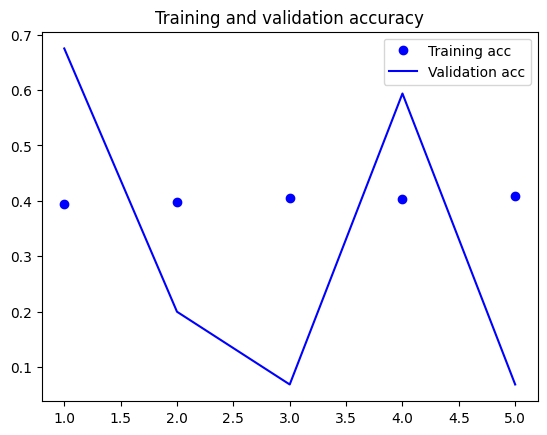

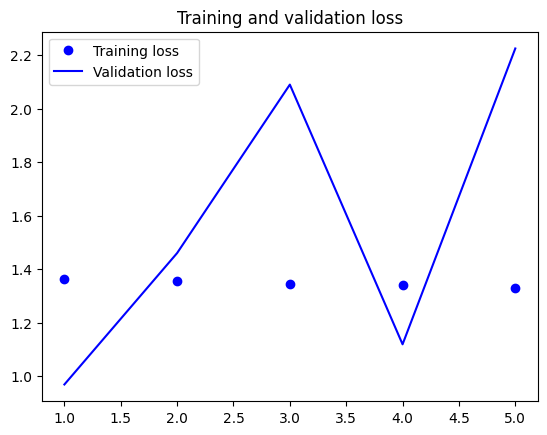

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)
# plot_history(history1)
# plot_history(history2)

In [ ]:
def run_test(model):
    num_test_samples = len(test_generator)
    batch_size = test_generator.batch_size

    print(num_test_samples, batch_size)

    steps = num_test_samples // batch_size

    test_loss, test_accuracy = model.evaluate(test_generator, batch_size=batch_size, steps=steps)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    return test_loss, test_accuracy

test_loss, test_accuracy = run_test(model)

220 32
6/6 [==============================] - 3s 490ms/step - loss: 2.1510 - accuracy: 0.0729
Test Loss: 2.150951385498047
Test Accuracy: 0.0729166641831398


In [ ]:
model.save('VGG16-novo.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report

def predict_one_img(model):
    image_path2 = 'E:\\retinopatia-dataset\\train\\10_right.jpeg'
    image2 = load_img(image_path2, target_size=(256, 256))  # Ensure the target size matches your model's input size
    image2 = img_to_array(image2)
    image2 = np.expand_dims(image2, axis=0)

    predictions = model.predict(image2)

    print(predictions)
    print(np.argmax(predictions, axis=1))

# predict_one_img(model1)
# predict_one_img(model2)
predict_one_img(model)

[[2.2984314e-13 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[1]


In [ ]:

# Faça previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


In [ ]:
print(y_pred)
print(y_pred_classes)
print(len(y_pred), len(y_pred_classes))
print(np.count_nonzero(y_pred_classes == 0))
print(np.count_nonzero(y_pred_classes == 1))
print(np.count_nonzero(y_pred_classes == 2))
print(np.count_nonzero(y_pred_classes == 3))
print(np.count_nonzero(y_pred_classes == 4))

[[2.93757588e-01 6.14525020e-01 8.99906456e-02 1.63722108e-03
  8.95685225e-05]
 [2.63778269e-01 6.47086442e-01 8.47495124e-02 4.19756304e-03
  1.88148158e-04]
 [2.57168174e-01 3.42300802e-01 2.12379515e-01 1.81893930e-01
  6.25756476e-03]
 ...
 [3.41933608e-01 5.37332654e-01 1.18674524e-01 1.67599192e-03
  3.83174192e-04]
 [3.16795945e-01 5.54188609e-01 1.22237720e-01 6.04680600e-03
  7.30935077e-04]
 [3.04583371e-01 4.06201035e-01 2.33363762e-01 4.82479595e-02
  7.60387862e-03]]
[1 1 1 ... 1 1 1]
7021 7021
579
6172
90
153
27


In [ ]:
y_test = [int(x) for x in y_test]
# y_test = y_test[0:len(y_test)-1]

# Imprima a acurácia
# print(f"Acurácia: {test_accuracy:.2f}")

# Imprima um relatório de classificação, que inclui precisão, recall, F1-score para cada classe
report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.08      0.15      5145
           1       0.07      0.90      0.14       509
           2       0.17      0.01      0.03      1061
           3       0.03      0.03      0.03       176
           4       0.00      0.00      0.00       130

    accuracy                           0.13      7021
   macro avg       0.20      0.21      0.07      7021
weighted avg       0.58      0.13      0.13      7021



In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

# Calcule a Área Sob a Curva (AUC) da Curva ROC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC da Curva ROC: {roc_auc:.2f}")

# Calcule o F1-score
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"F1-Score: {f1:.2f}")
f1 = f1_score(y_test, y_pred_classes, average='micro')
print(f"F1-Score (micro): {f1:.2f}")

AUC da Curva ROC: 0.50
F1-Score: 0.13
F1-Score (micro): 0.13


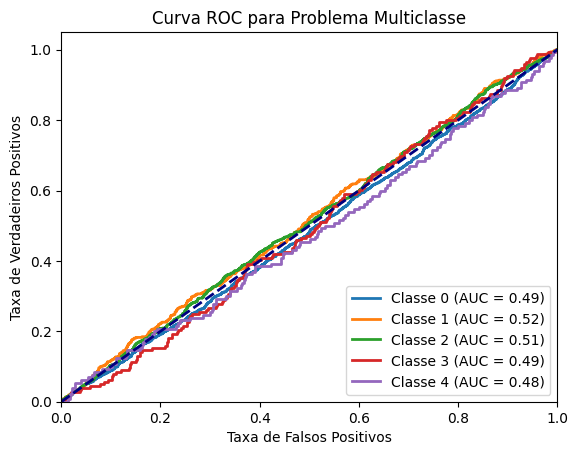

In [ ]:
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

# Transforme seus rótulos multiclasse em rótulos binários (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

# Inicialize as listas para armazenar as taxas de falsos positivos, verdadeiros positivos e AUCs
fpr = []
tpr = []
roc_auc = []

# Para cada classe, calcule a curva ROC e a AUC
for i in range(NUM_CLASSES):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

# Plote as curvas ROC para cada classe
plt.figure()
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Problema Multiclasse')
plt.legend(loc='lower right')
plt.show()